Importing required packages

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import dscribe
from ase.build import molecule
from dscribe.descriptors import SOAP
from ase.build import bulk
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.cube import read_cube, write_cube
from sklearn.metrics import explained_variance_score, mean_squared_error
import os
import sys
import numpy as np
import random
sys.path.append('deepcdp/')
from deepcdp import deepcdp
import sklearn.metrics as skmetrics
from sklearn.neural_network import MLPRegressor
import time

### Comparing the importance of weighting functions in SOAP
The idea is to generate a simple system and test how sensitive SOAP is (with and without the weighting function) from one atom to another.

Let's create a fcc Cu with just two atoms

In [2]:
# We will use ase's bulk function. Set up an orthorhombic cell. 
copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
cut = np.sqrt(1.8**2 + 1.8**2)
cut = copper_ortho.get_distance(0,1)
# cut off radius for SOAP. Not essential
print(fr'{cut: 1.2f} Angs.')

 2.55 Angs.


Generating the SOAP function with DScribe. Our SOAP is coded to be periodic along all three dimensions.

In [32]:
rcut = 2 # Local cut off
nmax = 4 # max number of radial basis functions
lmax = 4 # maximum degree of spherical harmonics

copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
print('Periodic = ',copper_ortho.get_pbc()) # checking for 
copper_soap_noW = SOAP( # noW = no weight
    species=[29],
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    periodic=False,
    sparse=False
)

Periodic =  [ True  True  True]


Viewing this system.

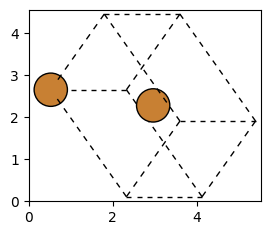

In [33]:
# view(copper_ortho, viewer='x3d') # uncomment this if you want to have an interactive view
fig, ax = plt.subplots(figsize=(3,3))
plot_atoms(copper_ortho, ax, radii=0.3, rotation=('45x,45y,0z'))
plt.show()


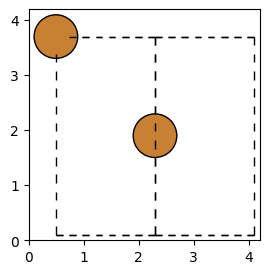

In [34]:
fig, ax = plt.subplots(figsize=(3,3))
plot_atoms(copper_ortho, ax, radii=0.3, rotation=('90x,45y,0z'))
plt.show()

Our task is to first sample few points (linearly) from one Cu atom to another. We then calculate the SOAP vectors for each of these points using our SOAP function. 

Let's pick seven such points, where the starting and the ending points are the two atom centers, respectively. 

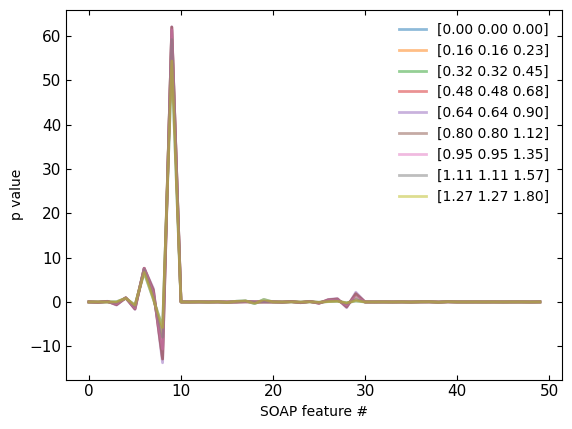

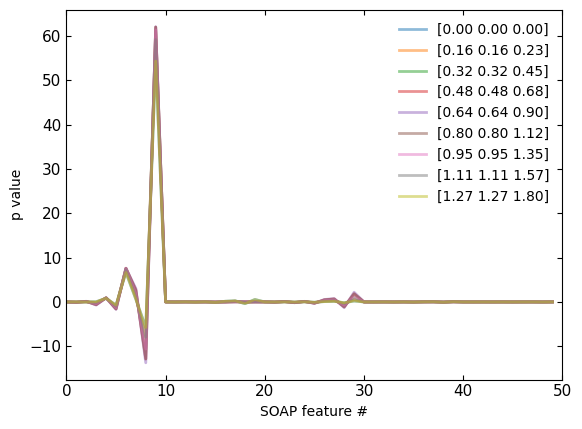

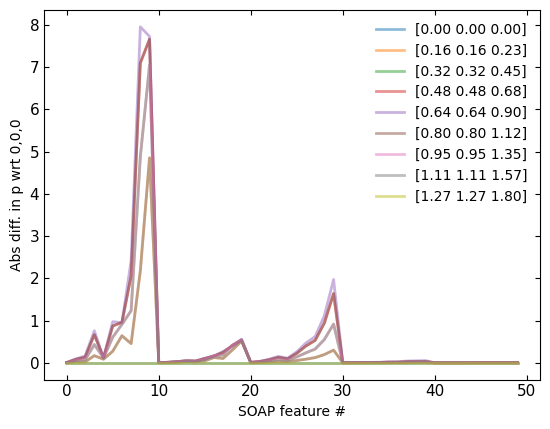

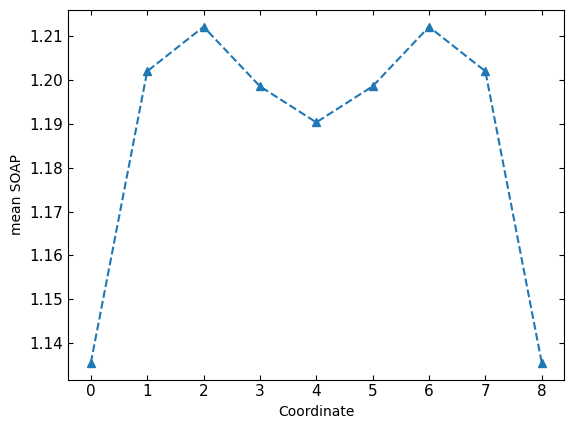

In [35]:
# Creating an points to multiply position vectors
multiplier = np.arange(0,1125,125)/1000 

# all position vectors from one Cu atom to another 
pos_vector = [(copper_ortho.get_positions()[1])*m 
              for m in multiplier]

# generating soap for each point
soap_copper_ortho = copper_soap_noW.create(copper_ortho,
                                         positions = pos_vector)
# plotting and storing the mean soap value
mean_soap = []
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_copper_ortho[i],
             label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
    mean_soap += [np.mean(soap_copper_ortho[i])]
plt.xlabel('SOAP feature #')
plt.ylabel('p value')
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

# plotting only the zoomed in section
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_copper_ortho[i],
             label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
plt.xlabel('SOAP feature #')
plt.ylabel('p value')
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.xlim(0,50)
plt.show()

# plotting the absolute deviation of soap vectors w.r.t soap at 0,0,0
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    diff=soap_copper_ortho[i]-soap_copper_ortho[0]
    plt.plot(np.abs(diff),label =f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.ylabel('Abs diff. in p wrt 0,0,0')
plt.xlabel('SOAP feature #')
plt.show()

# plotting mean soap value 
plt.plot(mean_soap,'^--')
plt.ylabel('mean SOAP')
plt.xlabel('Coordinate')
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

What we observe is that these SOAP vectors (p values) do not appear to be too sensitive to the location the point in space. We do see a trend in the mean SOAP plot, but the overall magnitude of these vectors are similar to each other over the different features. 

Let's see what happens when we include a weighting function (like the polynomial weighting).

In [53]:
rcut = 2.5 # Local cut off
nmax = 4 # max number of radial basis functions
lmax = 4 # maximum degree of spherical harmonics

copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
print('Periodic = ',copper_ortho.get_pbc()) # checking for 
copper_soap_W = SOAP( # noW = no weight
    species=[29],
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    periodic=False,
    sparse=False,
    weighting={"function":"poly","r0":1.5,"c":1,"m":1}
)

Periodic =  [ True  True  True]


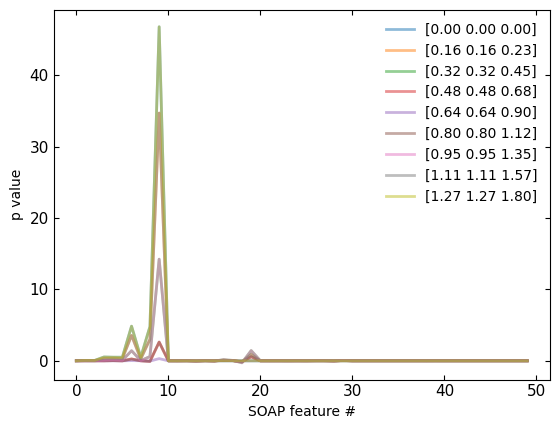

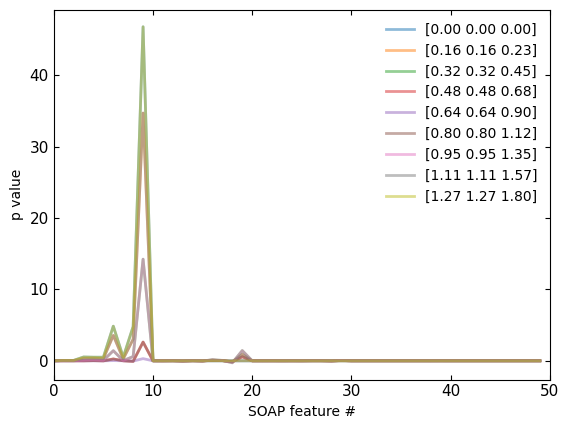

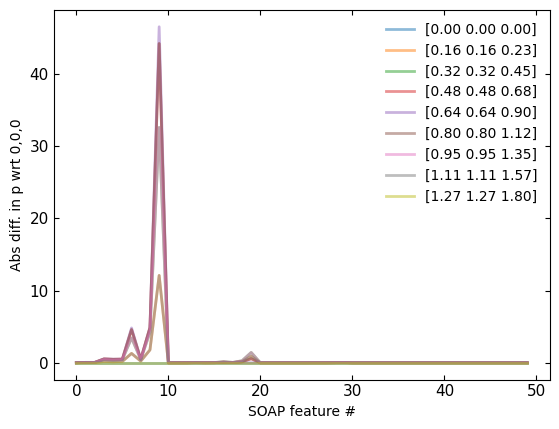

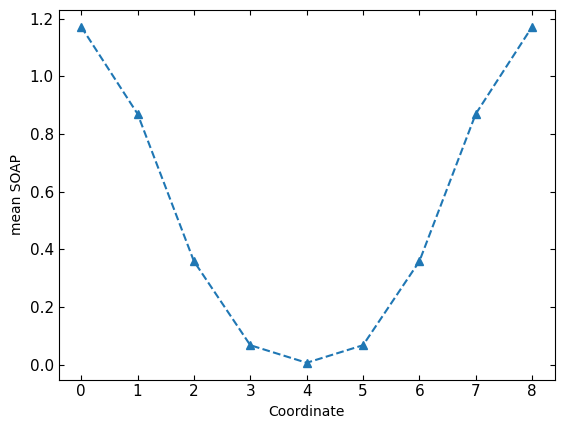

In [54]:
# Creating an points to multiply position vectors
multiplier = np.arange(0,1125,125)/1000 

# all position vectors from one Cu atom to another 
pos_vector = [(copper_ortho.get_positions()[1])*m 
              for m in multiplier]

# generating soap for each point
soap_copper_ortho = copper_soap_W.create(copper_ortho,
                                         positions = pos_vector)
# plotting and storing the mean soap value
mean_soap = []
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_copper_ortho[i],
             label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
    mean_soap += [np.mean(soap_copper_ortho[i])]
plt.xlabel('SOAP feature #')
plt.ylabel('p value')
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

# plotting only the zoomed in section
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_copper_ortho[i],
             label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
plt.xlabel('SOAP feature #')
plt.ylabel('p value')
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.xlim(0,50)
plt.show()

# plotting the absolute deviation of soap vectors w.r.t soap at 0,0,0
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    diff=soap_copper_ortho[i]-soap_copper_ortho[0]
    plt.plot(np.abs(diff),label =f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.ylabel('Abs diff. in p wrt 0,0,0')
plt.xlabel('SOAP feature #')
plt.show()

# plotting mean soap value 
plt.plot(mean_soap,'^--')
plt.ylabel('mean SOAP')
plt.xlabel('Coordinate')
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

There is more sentivity with the inclusion of weights, when compared to without. However, this does not indicate if the sensitivity provided by using this polynomial weighting function.

We will use a modest training set of six snapshots. The training data was generated for Cu fcc with 2 atoms in the cell. Let's first build a model using the non-weighted SOAP function. We will be using the MLPRegressor function in sklearn for convinience.

In [41]:
# Use the 6 DFT data points.
subsample=6

# Path of the file and filename prefix
datapath = 'data/bulk-Cu/train/'
datafilename = 'Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_' 
data_files = os.listdir(f'{datapath}')
idxList=[int(x.split('.cube')[0].split('_')[-1]) for x in data_files]
cubefile = lambda x:f'{datapath}{x}' # creating a lambda function

# generating an object of type deepcdp (imported)
CDP_noW=deepcdp(copper_soap_noW)

# generates a box of points. Be mindful of the gamma value used.
CDP_noW.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])
data_files = os.listdir(datapath)

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']

# randomly picking snapshots for training
data_files_sub = random.choices(data_files, k=subsample)

# generating final dataset
CDP_noW.generate_cube_data(data_files_sub,cubefile,sampleSubs)


Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube
SOAP is of dimension: (5175, 50)
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_82.cube
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_220.cube
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_2.cube
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_300.cube
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_220.cube


(array([[ 5.00446829e-05,  6.37619898e-03, -5.53034206e-03, ...,
          8.53624739e-03, -8.65045320e-03,  8.76618697e-03],
        [ 4.59994568e-11,  6.22549514e-06, -5.85325956e-06, ...,
          9.06972623e-03, -9.32279756e-03,  9.58293032e-03],
        [ 1.31018891e-04, -1.05735883e-02,  1.11497419e-02, ...,
          9.27556638e-03, -9.66019726e-03,  1.00607795e-02],
        ...,
        [ 3.61724562e-03, -1.88139597e-02,  5.00476327e-02, ...,
          7.26104176e-03, -7.93437656e-03,  8.67024761e-03],
        [ 3.36957071e-03, -1.64648691e-02,  4.53935076e-02, ...,
          8.24552610e-03, -8.90357052e-03,  9.61417981e-03],
        [ 2.99901132e-03, -1.39231157e-02,  3.94733483e-02, ...,
          8.98564317e-03, -9.57270824e-03,  1.01981525e-02]]),
 array([5.4990e-05, 1.1848e+00, 2.0134e+00, ..., 1.2582e+00, 2.5435e+00,
        2.7732e+00]))

The CDP_noW object stores the training X (SOAP) and Y (densities). 

In [42]:
CDP_noW.trainX.shape, int(CDP_noW.trainX.shape[0]/6), CDP_noW.trainY.shape, 

((31050, 50), 5175, (31050,))

There are a total of 31050 points samples from these 6 images. Each image contains 5175 points. The SOAPs correspond to 324 features. Let's use this data to train a model. 

In [43]:
# training a model
start = time.time()
model_Cu_noW = MLPRegressor(hidden_layer_sizes=(100,100,100),
                           random_state=3,
                           max_iter=300, 
                           shuffle=True,
                           batch_size=500).fit(CDP_noW.trainX, 
                                               CDP_noW.trainY) 
end = time.time()
print("Training: ", (end - start), " seconds.")

Training:  60.00725293159485  seconds.


In [44]:
skmetrics.r2_score(model_Cu_noW.predict(CDP_noW.trainX),
                   CDP_noW.trainY)
# TODO: write some text about these predictions
# TODO: make 3d plots of the predicted densities
# TODO: make 2d plots of the predictions. 
# TODO: Find a plane where a contour plot will be handy.

0.3600063727406936

Let's now generate a model using the weighted-SOAP function for Cu. 

In [55]:
# Use the 6 DFT data points.
subsample=6

# Path of the file and filename prefix
datapath = 'data/bulk-Cu/train/'
datafilename = 'Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_' 
data_files = os.listdir(f'{datapath}')
idxList=[int(x.split('.cube')[0].split('_')[-1]) for x in data_files]
cubefile = lambda x:f'{datapath}{x}' # creating a lambda function

# generating an object of type deepcdp (imported)
CDP_W=deepcdp(copper_soap_W)

# generates a box of points. Be mindful of the gamma value used.
CDP_W.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])
data_files = os.listdir(datapath)

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']

# randomly picking snapshots for training
data_files_sub = random.choices(data_files, k=subsample)

# generating final dataset
CDP_W.generate_cube_data(data_files_sub,cubefile,sampleSubs)


Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_2.cube
SOAP is of dimension: (5175, 50)
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_2.cube
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_2.cube
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_220.cube
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_82.cube
Read file: data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_220.cube


(array([[ 6.04799243e-03,  5.51140106e-02,  5.45823411e-02, ...,
          3.27535941e-21, -5.13553019e-21,  8.05214544e-21],
        [ 5.17576124e-03,  4.87412039e-02,  4.64404210e-02, ...,
          4.86283926e-10, -7.61274669e-10,  1.19177108e-09],
        [ 3.29764692e-03,  3.43640472e-02,  2.90081917e-02, ...,
          8.50716420e-08, -1.32590570e-07,  2.06652404e-07],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array([6.4370e-05, 1.2862e+00, 1.9644e+00, ..., 1.2582e+00, 2.5435e+00,
        2.7732e+00]))

In [ ]:
# training a model
start = time.time()
model_Cu_W = MLPRegressor(hidden_layer_sizes=(300,200,100),
                           random_state=1,
                           max_iter=300, 
                           shuffle=True,
                         ).fit(CDP_W.trainX, 
                                               CDP_W.trainY) 
end = time.time()
print("Training: ", (end - start), " seconds.")

In [ ]:
skmetrics.r2_score(model_Cu_W.predict(CDP_W.trainX),
                   CDP_W.trainY)
# TODO: write some text about these predictions
# TODO: make 3d plots of the predicted densities
# TODO: make 2d plots of the predictions. 
# TODO: Find a plane where a contour plot will be handy.

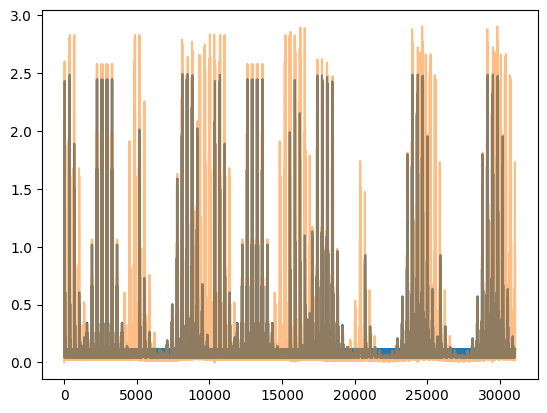

In [50]:
plt.plot(model_Cu_W.predict(CDP_W.trainX))
plt.plot(CDP_W.trainY,alpha=0.5)